template matching 第5弾
近傍の変位量と比較するフィルターの導入で異常値を除外  

データ保存機能を追加  
Lastly upsated on 26 Oct. 2025 by Hiromu Daimaru


In [1]:
# Colab にはrasterioが入っていないのでインストールする
!pip install rasterio
# fionaもインストール
!pip install fiona
# pycrsもインストール
!pip install pycrs

  Preparing metadata (setup.py) ... done
  Created wheel for pycrs: filename=PyCRS-1.0.2-py3-none-any.whl size=32686 sha256=b7816b6b000a5b2d7ef58ccd2387dbead107156ae9ed1e8350df245c84558ef6
  Stored in directory: /root/.cache/pip/wheels/b5/4a/72/1ba05f57ddf2cc80ad21a26512097762561d646ff3ff85f729
Successfully built pycrs


In [2]:
# ライブラリのインポート
import cv2
import numpy as np
from matplotlib import pyplot as plt
from osgeo import gdal
import folium
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import shapely
import rasterio
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.mask import mask
from shapely.geometry import box
import geopandas as gpd
from fiona.crs import from_epsg
import pycrs
import os
%matplotlib inline

In [ ]:
# 解析用ファイルのダウンロード
import gdown
# Google Drive 共有ファイルID
file_id_af = "1TujWEA7cf91GJQs2PYuu25aXKXInqHe5"
file_id_bf = "1CtKBV6IndaHTEspJjDKagERQx7KLTYeR"

# 保存名（ローカルColab環境内）
output_af = "af_shade_ED673_881.tif"
output_bf = "bf_shade_ED673_881.tif"

# ダウンロード実行
gdown.download(f"https://drive.google.com/uc?id={file_id_af}", output_af, quiet=False)
gdown.download(f"https://drive.google.com/uc?id={file_id_bf}", output_bf, quiet=False)

print("Download completed.")

rasterio による clipping  
https://automating-gis-processes.github.io/CSC18/lessons/L6/clipping-raster.html

In [3]:
# Google Drive のマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


広域の陰影図の指定（GoogleDriveよりダウンロード）

In [ ]:
# 陰影図の指定
fp_afs = "af_shade_ED673_881.tif"
fp_bfs = "bf_shade_ED673_881.tif"


# 陰影図とdemのpathを指定する

# 輪島市町野町真喜野地区
# fp_afs = "/content/drive/MyDrive/template_matching/makino/af_shade/af_shade_ED673_881.tif"
# fp_bfs = "/content/drive/MyDrive/template_matching/makino/bf_shade/bf_shade_ED673_881.tif"
# 輪島市町野地区
# fp_afs = "/content/drive/MyDrive/template_matching/machino/af_shade/af_ed683_ed784.tif"
# fp_bfs = "/content/drive/MyDrive/template_matching/machino/bf_shade/bf_ed_683_ed784.tif"
# fp_afs = "/content/drive/MyDrive/template_matching/kotokuji/af_shade/af_shade_07FD031_144.tif"
# fp_bfs = "/content/drive/MyDrive/template_matching/kotokuji/bf_shade/bf_shade_07FD031_144.tif"

In [5]:
# 指定した数の上層の path を返す関数
def get_parent_path(path, levels=1):
    """
    Returns the parent path of a given path, going up a specified number of levels.

    Args:
        path (str): The input path.
        levels (int): The number of levels to go up (default is 1).

    Returns:
        str: The parent path.
    """
    parent_path = path
    for _ in range(levels):
        parent_path = os.path.dirname(parent_path)
    return parent_path

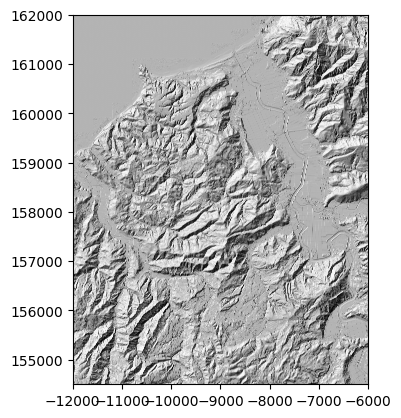

<Axes: >

In [6]:
# 地震後の陰影図全体をrasterioで読み込む
af_data = rasterio.open(fp_afs)
# rasterio.plot.show でデータを表示
show((af_data, 1), cmap='gray')

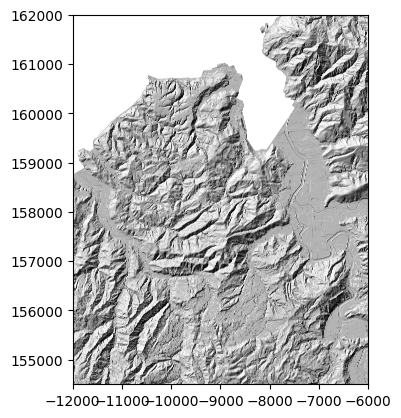

<Axes: >

In [7]:
# 地震前の陰影図全体をrasterioで読み込む
bf_data = rasterio.open(fp_bfs)
# rasterio.plot.show でデータを表示
show((bf_data, 1), cmap='gray')

In [8]:
# bounding box を設定する
# 南西端の座標（xmin, ymin）を指定すれば、それに area_size が加算された領域が bbox として定義される
area_size = 1000
# minx, miny = 1500, 163500
# maxx, maxy = 2500, 164500
# minx, miny = -7000, 156500
# maxx, maxy = -5000, 154000
# 渋田地区をターゲットに x, y の最小値と最大値を設定する
# minx, miny = -10400, 158500
minx, miny = -10400, 158500
maxx, maxy = minx + area_size, miny + area_size
bbox = box(minx, miny, maxx, maxy)

In [9]:
# 平面直角7系のEPSGコードを設定しておく
epsg_code = 6675

In [10]:
# geodataframe の座標を表示する関数を定義
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [11]:
# ラスターを指定範囲でクリップしてそのパスを返す関数
def clip_raster(fp, x1: int, y1: int, x2: int, y2:int, epsg_code):
  data = rasterio.open(fp)
  # geopandas でbboxのgeodataframeを作成する
  geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(6675))
  # getFeature 関数を使ってbboxの座標をcorrdsとして取得
  coords = getFeatures(geo)
  # data からcoordの示す範囲内のデータを切り出す
  out_img, out_transform = mask(dataset=data, shapes=coords, crop=True)
  # 元のメタファイルを出力用のout_metaにコピーしておく
  out_meta = data.meta.copy()
  out_meta.update({"driver": "GTiff",
                 "height": out_img.shape[1],
                 "width": out_img.shape[2],
                 "transform": out_transform,
                 "crs": epsg_code})
  # geotiffを出力するpathの設定
  # ファイル名の設定 x座標については- (マイナス)をファイル名に使いたくないのでwに置換する
  fl = str(x1).replace('-', 'w') + "_" + str(y1) + "_" + str(x2).replace('-', 'w') + "_" + str(y2) + ".tif"
  # 出力先フォルダーの設定（元ファイルと同じ）
  #dr = fp[0:(-1*len(fp_afs.split("/")[-1]))]
  dr = os.path.dirname(fp)
  # out_tif = dr + "/" + fl
  out_tif = os.path.join(dr, fl)
  #print(out_tif)
  # 出力先にファイルを出力
  # Create the necessary directories if they don't exist
  os.makedirs(dr, exist_ok=True)
  with rasterio.open(out_tif, "w", **out_meta) as dest:
    dest.write(out_img)
  # 出力ファイルのpathを戻り値として返す
  return out_tif
  # out_tif = dr + "/" + fl
  out_tif = os.path.join(dr, fl)
  #print(out_tif)
  # 出力先にファイルを出力
  with rasterio.open(out_tif, "w", **out_meta) as dest:
    dest.write(out_img)
  # 出力ファイルのpathを戻り値として返す
  return out_tif

In [12]:
# 広域ラスター (shade) から地震前後の指定領域をクリップする
bfs_clipped = clip_raster (fp_bfs, minx, miny, maxx, maxy, epsg_code)
afs_clipped = clip_raster (fp_afs, minx, miny, maxx, maxy, epsg_code)

print(afs_clipped)

/tmp/ipython-input-3249274403.py:2: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  bfs_clipped = clip_raster (fp_bfs, minx, miny, maxx, maxy, epsg_code)
/tmp/ipython-input-3249274403.py:3: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  afs_clipped = clip_raster (fp_afs, minx, miny, maxx, maxy, epsg_code)


/content/drive/MyDrive/template_matching/makino/af_shade/w10400_158500_w9400_159500.tif


In [13]:
# グレースケールでクリップ領域の地震前後の画像を読み込む
af_image = cv2.imread(afs_clipped, cv2.IMREAD_GRAYSCALE)
bf_image = cv2.imread(bfs_clipped, cv2.IMREAD_GRAYSCALE)

# データが存在しない場合は警告する
if af_image is None:
    raise ValueError(f"Could not load image from path: {afs_clipped}")
if bf_image is None:
    raise ValueError(f"Could not load image from path: {bfs_clipped}")

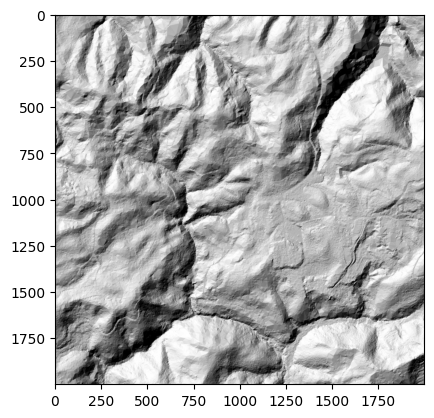

In [14]:
#　クリップ領域の地震前の陰影図を表示
plt.imshow(bf_image, cmap='gray')

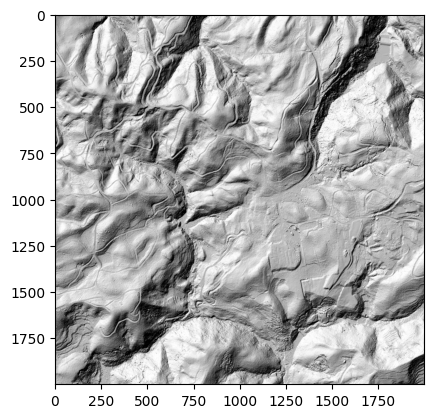

In [15]:
#　クリップ領域の地震後の陰影図を表示
plt.imshow(af_image, cmap='gray')

In [16]:
# GDALで地図データの情報を取得
# https://gis4programmers.wordpress.com/2017/01/06/using-gdal-to-get-raster-extent/
# upy は画像南西のy座標らしい、平面直角なのでskewは0となる
bf_Src = gdal.Open(bfs_clipped)
upx, xres, xskew, upy, yskew, yres = bf_Src.GetGeoTransform()

/usr/local/lib/python3.12/dist-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [17]:
# ピクセル座標を平面直角の地理座標（m）に変換する関数
def px2coords(px, py, upx, upy, xres, yres):
    x = upx + (px * xres)
    #y = upy - (py * yres)
    y = upy + (py * yres)
    return x, y

In [18]:
# Template matching の実行（すべて計算）
# 画像のサイズ（pixel）を取得
x_size, y_size = bf_image.shape[0], bf_image.shape[1]
# テンプレート画像のサイズ（pixel単位）を設定する
win_size = 100

# データを格納するための空の配列を作成する
# 元画像のテンプレート取得元の北西端のピクセルx座標
l_nw_px =[]
# 元画像のテンプレート取得元の北西端のピクセルy座標
l_nw_py =[]

# 元画像のテンプレート取得元の南東端のピクセルx座標
l_se_px =[]
# 元画像のテンプレート取得元の南東端のピクセルy座標
l_se_py =[]

# 元画像のテンプレート取得元の中心ピクセル座標
l_center_px = []
l_center_py = []
# 平面直角座標
l_center_mx = []
l_center_my = []

# 照合先のピクセルx座標
l_target_px = []
# 照合先ピクセルy座標
l_target_py = []

# 照合先のメートルx座標（平面直角）
l_target_mx = []
# 照合先のメートルy座標（平面直角）
l_target_my = []

# 類似度
l_cr = []

# 変位量のx成分 pixel単位
l_dpx = []
# 変位量のy成分 pixel単位
l_dpy = []

# 変位量のx成分 m単位
l_dmx = []
# 変位量のy成分 m単位
l_dmy = []

# 変位量 m単位: dmx と dmy の平方和
l_dm =[]

# step はテンプレートのサイズの半分に設定する
step = int(win_size / 2)

# 開始点と終了点の設定
# 誤差を低減するために縁辺部は含まない
start = win_size
end_x = x_size - win_size
end_y = y_size - win_size

# yを北から南に移動
for y0 in range (start, end_y, step):
  # xを西から東に移動
  for x0 in range (start, end_x, step):
    # テンプレート画像の南東のピクセル座標を取得
    x1 = x0 + win_size
    y1 = y0 + win_size

    # テンプレート画像の取得
    # 地震前の画像（bf_image）の numpy array からテンプレート用の画像データを直接切り取っています。numpyの場合は、行 > 列の順でアドレスを指定するので
    # y->xの順になることに注意してください。
    template = bf_image[y0:y1, x0:x1]

    # テンプレートマッチングを実行
    result = cv2.matchTemplate(af_image, template, cv2.TM_CCOEFF_NORMED)
    # 最小値と最大値の位置を取得
    # 参考　https://www.codevace.com/py-opencv-min-max/
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

    # 類似度が最大になる場所のx, y のpixel座標を取得する
    target_px, target_py = max_loc[0], max_loc[1]

    # 類似度が最大になる場所のメートル（平面直角）
    target_mx = px2coords(target_px, target_py, upx, upy, xres, yres)[0]
    target_my = px2coords(target_px, target_py, upx, upy, xres, yres)[1]

    # 元画像のテンプレートの位置と類似度最大値の位置との差から変位量を取得
    # 北への移動と東への移動がそれぞれ正となる
    # pixelの差
    dpx = max_loc[0] - x0
    # m に換算
    dxm = dpx * xres

    # pixelの差
    dpy = max_loc[1] - y0
    # m に換算
    dym = dpy * yres

    # 変位量（dxmとdymの平方和）を算出
    dm = np.hypot(dxm, dym)

    # 結果を出力する
    # テンプレートの北西端の座標データを追加
    l_nw_px.append(x0)
    l_nw_py.append(y0)

    # テンプレートの南東端の座標データを追加
    l_se_px.append(x1)
    l_se_py.append(y1)

    # テンプレートの中心点の座標データを追加
    center_px = int((x0 + x1)*0.5)
    center_py = int((y0 + y1)*0.5)
    l_center_px.append(center_px)
    l_center_py.append(center_py)
    center_mx = px2coords(center_px, center_py, upx, upy, xres, yres)[0]
    center_my = px2coords(center_px, center_py, upx, upy, xres, yres)[1]
    l_center_mx.append(center_mx)
    l_center_my.append(center_my)


    # 照合先ピクセルの位置をリストに追加
    l_target_px.append(target_px)
    l_target_py.append(target_py)

    # 照合先の位置のm座標をリストに追加
    l_target_mx.append(target_mx)
    l_target_my.append(target_my)
    # 類似度のリストへの追加
    l_cr.append(max_val)
    # 変位量データの追加（pixel）
    l_dpx.append(dpx)
    l_dpy.append(dpy)
    # 変位量データの追加（m）
    l_dmx.append(dxm)
    l_dmy.append(dym)
    # 変位量データの追加（m）の平方和
    l_dm.append(dm)



In [19]:
# 生成された配列の本来の行列数の計算
rows, cols = int((end_y - start)/step), int((end_x - start)/step)

In [20]:
# 変位量の array を作成する
ar_dm = np.array(l_dm).reshape(rows, cols)

In [21]:
# 有効性を検定するために周囲との偏差を計算する
# 8近傍に類似地が存在するかどうかチェックする

# 周囲との偏差の最小値の配列
# Iterate through the array, excluding the border rows and columns
ar_mindif_dm = np.empty((rows,cols))
ar_mindif_dm.fill(np.nan) # Initialize with NaN
#ar_mindif_dm

In [22]:
# 近隣4セルとの差の最小値を求める
# 周囲のどの値よりも突出した単独の異常値を探す
# Create an empty array to store the minimum differences

# Iterate through the array, excluding the border rows and columns
# r行c列の要素に対して周囲8近傍との差を求める
# 隣接セルの無い端は欠落域とするので 1～ cols (rows) - 1 について計算する
for r in range(1, rows - 1):
    for c in range(1, cols - 1):
        center_val = ar_dm[r, c]
        # Get the values of the adjacent cells
        neighbors = [
            ar_dm[r-1, c], # Up
            ar_dm[r-1, c-1], # UpLeft
            ar_dm[r-1, c+1], # UpRight
            ar_dm[r+1, c], # Down
            ar_dm[r+1, c-1], # DownLeft
            ar_dm[r+1, c+1], # DownRight
            ar_dm[r, c-1], # Left
            ar_dm[r, c+1]  # Right

        ]
        # Calculate the absolute differences
        differences = [abs(center_val - neighbor) for neighbor in neighbors if not np.isnan(neighbor)]
        # Find the minimum absolute difference
        if differences:
            ar_mindif_dm[r, c] = min(differences)

print("Minimum differences from adjacent cells calculated and stored in ar_mindif_l_dm_valid")

# array に変換する
l_mindif_dm = ar_mindif_dm.flatten()


Minimum differences from adjacent cells calculated and stored in ar_mindif_l_dm_valid


In [23]:
# ベクターマップにプロットする要素の条件を設定する
# 周囲との移動量の差の閾値を設定
thres_dif = 1.0
# 類似度の閾値を設定（類似度がこれ以上の場合に有効化）
threshold = 0.8
# 変位量の閾値を設定（変位量がこれ以下の場合に有効化、これ以上はエラーとみなす; m単位）
thres_dm =20

In [24]:
# 地震前のテンプレートの中心座標（ｍ単位：JGD2011平面直角７系）からgeopandasでジオデータフレームを作成する
ar_points = np.array([l_center_mx, l_center_my]).T
points = shapely.points(ar_points)
IN_EPSG = 'EPSG:6675'

gdf = (
    gpd.GeoDataFrame(
        geometry=points,
        crs=IN_EPSG
    )
)
# 作成したgeodataframe: gdfに変位量のxy成分、変位量の大きさ、類似度を追加する
# gdf['center_x'] = l_center_mx
# gdf['center_y'] = l_center_my
gdf['dx'] = l_dmx
gdf['dy'] = l_dmy
gdf['d'] = l_dm
gdf['cr'] = l_cr
gdf['mindif'] = l_mindif_dm
# 有効性の計算 gdf['cr'] > threshold, gdf['d'] < thres_dm, gdf['mindif'] < thres_dif のすべての条件を満たすときに validity=1 とする
gdf['validity'] = np.where((gdf['cr'] > threshold) * (gdf['d'] < thres_dm) * (gdf['mindif'] < thres_dif), 1, 0)


# tilemap で描画するため、gdf の座標系をWGS1984に変換する
gdf = gdf.to_crs(epsg=4326)

# 出力先の path
parent_path = get_parent_path(bfs_clipped,2)
# 出力するファイル名
fln_pkl = bfs_clipped.split('/')[-1].split('.')[0] + "_w" + str(win_size) + ".pkl"
path_pkl = os.path.join(parent_path, fln_pkl)
gdf_to_pkl = gdf.to_pickle(path_pkl)

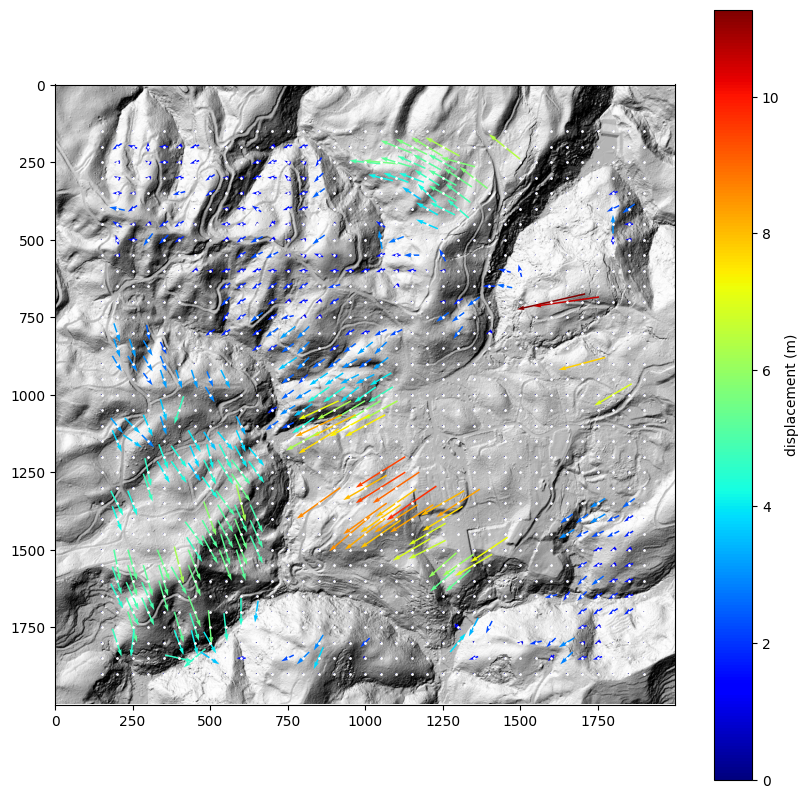

In [25]:
# ベクターマップの画面出力 周囲との差の最小値が thres_dif より小さい場合のみプロットする
#print(f'中心座標 pixel: {center_p}')
#print(f'座標 m: {center_xycord}')
# print(f'類似度: {max_val}')
# print(f'dx: {dxm}m, dy: {dym}m')

fln = bfs_clipped.split('/')[-1].split('.')[0] + "_w" + str(win_size) + ".png"
#out_fig_path = "/content/drive/MyDrive/IPU_Share/learning_opencv/template_matching/kamishoriki/fig"
out_fig_path = "/content/drive/MyDrive/template_matching/machino/fig"
out_path = os.path.join(out_fig_path, fln)

#　地震後の陰影図を表示してその上にベクトルを表示
# pivot = "mid" で線分の中央点に合わせる

# 類似度 l_cr 変位量 l_dm 変位量の周囲との差 l_mindif_dm を用いて有効な値のみを与えた配列を作成（無効な値は0）
l_dmx_valid = [l_dmx[i] if (l_cr[i] > threshold) * (l_dm[i] < thres_dm) * (l_mindif_dm[i] < thres_dif) else 0 for i in range(len(l_dmx))]
l_dmy_valid = [l_dmy[i] if (l_cr[i] > threshold) * (l_dm[i] < thres_dm) * (l_mindif_dm[i] < thres_dif) else 0 for i in range(len(l_dmy))]
l_dm_valid = [l_dm[i] if (l_cr[i] > threshold) * (l_dm[i] < thres_dm)* (l_mindif_dm[i] < thres_dif) else 0 for i in range(len(l_dm))]
l_dpx_valid = [l_dpx[i] if (l_cr[i] > threshold) * (l_dm[i] < thres_dm)  * (l_mindif_dm[i] < thres_dif) else 0 for i in range(len(l_dpx))]
l_dpy_valid = [l_dpy[i] if (l_cr[i] > threshold) * (l_dm[i] < thres_dm)  * (l_mindif_dm[i] < thres_dif) else 0 for i in range(len(l_dpy))]

# Filter out None values for plotting
plot_dpx = np.array([val for val in l_dpx_valid if val is not None]) * xres
plot_dpy = np.array([val for val in l_dpy_valid if val is not None]) * yres
plot_center_px = np.array([l_center_px[i] for i, val in enumerate(l_dpx_valid) if val is not None])
plot_center_py = np.array([l_center_py[i] for i, val in enumerate(l_dpy_valid) if val is not None])
plot_dm_valid = np.array([val for val in l_dm_valid if val is not None])

# ベクトルの大きさを計算、値が小さいと色が表示されないので100をかけてcm単位とする
#mag = np.hypot(l_dpx, l_dpy) * 100 * xres
# mag = np.hypot(plot_dpx, plot_dpy) * 100
mag = plot_dm_valid

fig, ax = plt.subplots(figsize = (10, 10))
ax.imshow(af_image, cmap='gray')
Q = ax.quiver(plot_center_px, plot_center_py, plot_dpx, plot_dpy, mag, pivot ="mid", cmap='jet', scale_units='xy', scale=0.05)
# Q = ax.quiver(l_center_px, l_center_py, plot_dpx, plot_dpy, mag, pivot ="mid", cmap='jet', scale_units='xy', scale=0.1)

fig.colorbar(Q, label='displacement (m)')
ax.scatter(l_center_px, l_center_py, color='white', s =1)

plt.savefig(out_path)

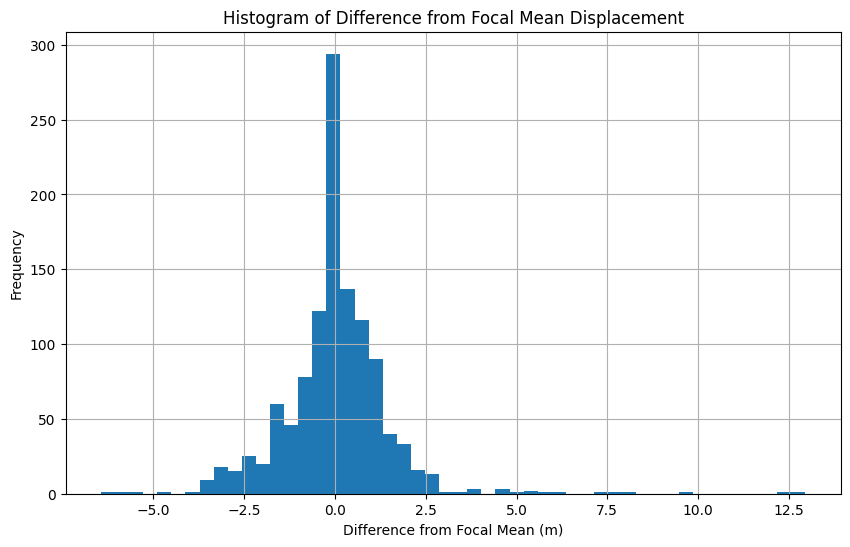

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(l_dif_l_dm_valid, bins=50)
plt.title('Histogram of Difference from Focal Mean Displacement')
plt.xlabel('Difference from Focal Mean (m)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
# 画面出力 l_dif_l_dm
#print(f'中心座標 pixel: {center_p}')
#print(f'座標 m: {center_xycord}')
# print(f'類似度: {max_val}')
# print(f'dx: {dxm}m, dy: {dym}m')

fln = bfs_clipped.split('/')[-1].split('.')[0] + "_w" + str(win_size) + ".png"
#out_fig_path = "/content/drive/MyDrive/IPU_Share/learning_opencv/template_matching/kamishoriki/fig"
out_fig_path = "/content/drive/MyDrive/template_matching/machino/fig"
out_path = os.path.join(out_fig_path, fln)

#　地震後の陰影図を表示してその上にベクトルを表示
# pivot = "mid" で線分の中央点に合わせる

# 類似度 l_cr を用いて有効な値のみを与えた配列を作成（無効な値はNone）
l_dmx_valid = [l_dmx[i] if l_cr[i] > threshold else 0 for i in range(len(l_dmx))]
l_dmy_valid = [l_dmy[i] if l_cr[i] > threshold else 0 for i in range(len(l_dmy))]
l_dm_valid = [l_dm[i] if (l_cr[i] > threshold) * (l_dm[i] < thres_dm) else 0 for i in range(len(l_dm))]
l_dpx_valid = [l_dpx[i] if (l_cr[i] > threshold) * (l_dm[i] < thres_dm) else 0 for i in range(len(l_dpx))]
l_dpy_valid = [l_dpy[i] if (l_cr[i] > threshold) * (l_dm[i] < thres_dm) else 0 for i in range(len(l_dpy))]

# Filter out None values for plotting
plot_dpx = np.array([val for val in l_dpx_valid if val is not None]) * xres
plot_dpy = np.array([val for val in l_dpy_valid if val is not None]) * yres
plot_center_px = np.array([l_center_px[i] for i, val in enumerate(l_dpx_valid) if val is not None])
plot_center_py = np.array([l_center_py[i] for i, val in enumerate(l_dpy_valid) if val is not None])
plot_dm_valid = np.array([val for val in l_dm_valid if val is not None])

# ベクトルの大きさを計算、値が小さいと色が表示されないので100をかけてcm単位とする
#mag = np.hypot(l_dpx, l_dpy) * 100 * xres
# mag = np.hypot(plot_dpx, plot_dpy) * 100
mag = plot_dm_valid

fig, ax = plt.subplots(figsize = (10, 10))
ax.imshow(af_image, cmap='gray')
Q = ax.quiver(plot_center_px, plot_center_py, plot_dpx, plot_dpy, mag, pivot ="mid", cmap='jet', scale_units='xy', scale=0.05)
# Q = ax.quiver(l_center_px, l_center_py, plot_dpx, plot_dpy, mag, pivot ="mid", cmap='jet', scale_units='xy', scale=0.1)

fig.colorbar(Q, label='vectorrr size (cm)')
ax.scatter(l_center_px, l_center_py, color='white', s =1)

plt.savefig(out_path)

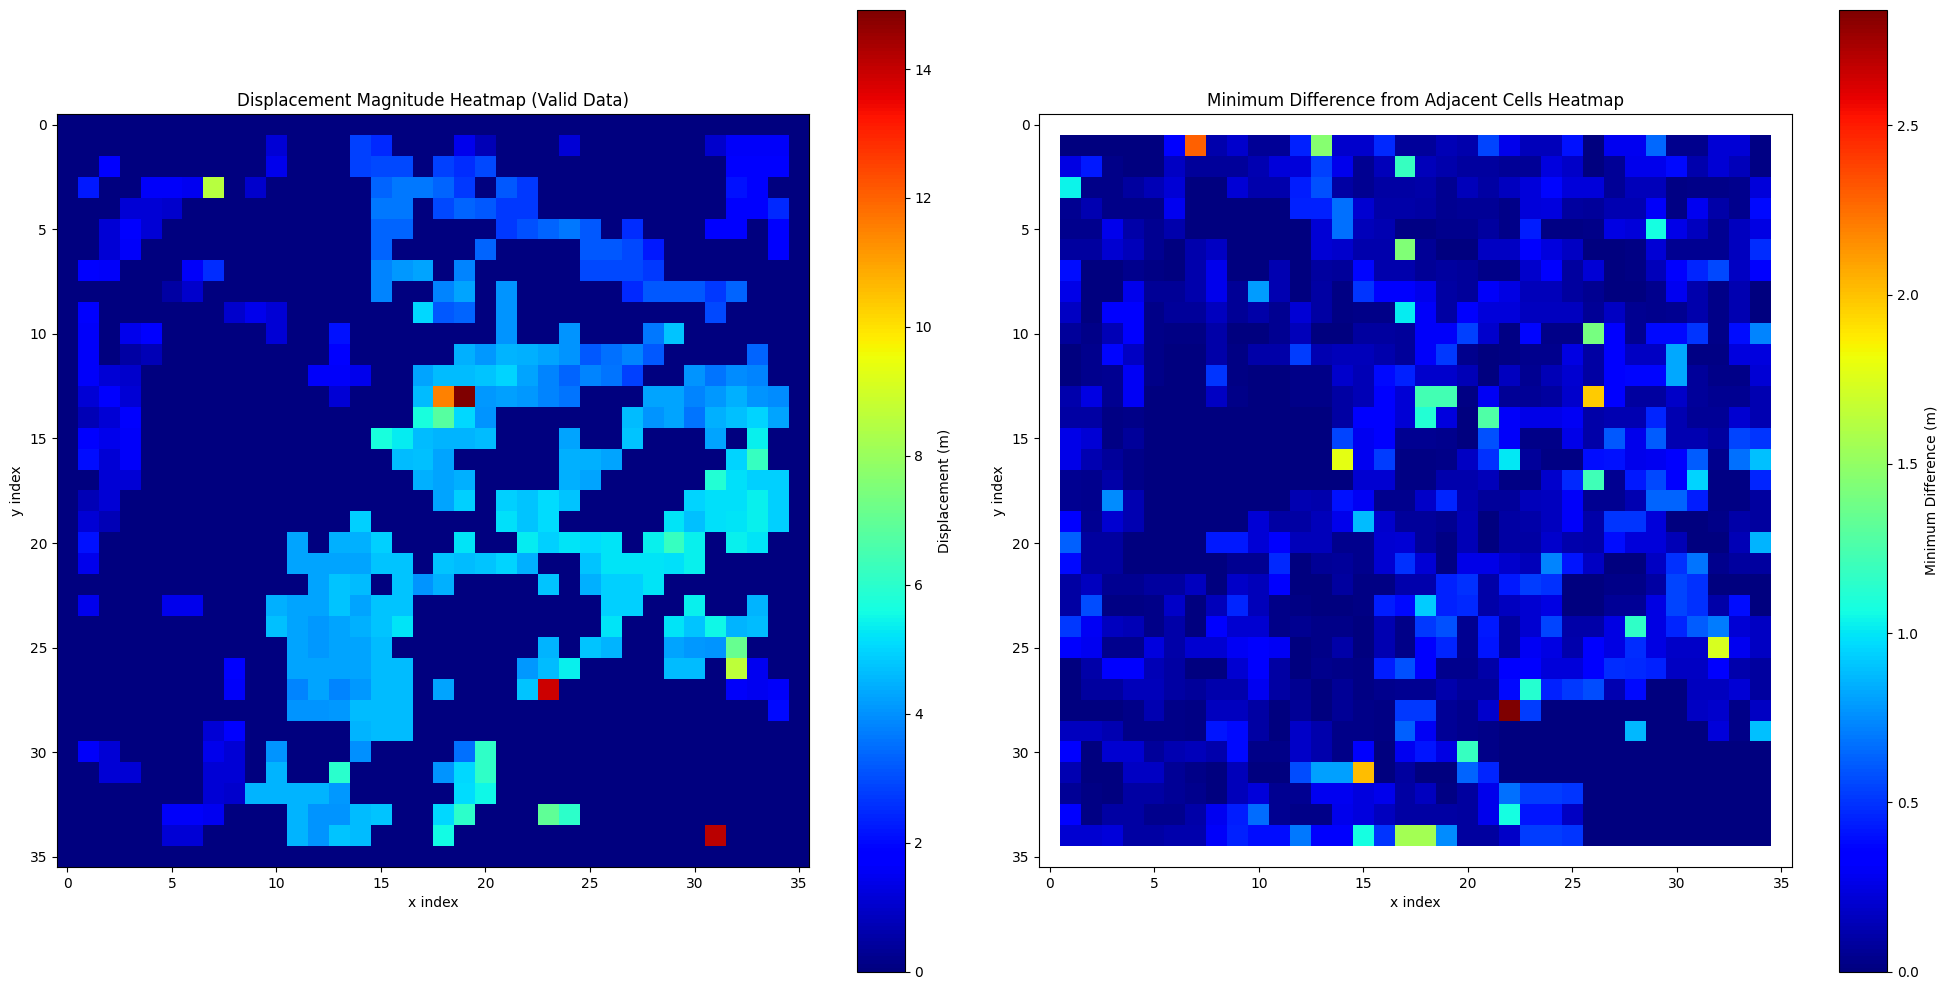

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
ar_l_dm_valid = np.reshape(l_dm_valid, (rows, cols))

# Heatmap for ar_l_dm_valid
im1 = axes[0].imshow(ar_l_dm_valid, cmap='jet')
fig.colorbar(im1, ax=axes[0], label='Displacement (m)')
axes[0].set_title('Displacement Magnitude Heatmap (Valid Data)')
axes[0].set_xlabel('x index')
axes[0].set_ylabel('y index')

# Heatmap for ar_mindif_l_dm_valid
im2 = axes[1].imshow(ar_mindif_l_dm_valid, cmap='jet')
fig.colorbar(im2, ax=axes[1], label='Minimum Difference (m)')
axes[1].set_title('Minimum Difference from Adjacent Cells Heatmap')
axes[1].set_xlabel('x index')
axes[1].set_ylabel('y index')

plt.tight_layout()
plt.show()

In [ ]:
l_dif_l_dm_valid

array([nan, nan, nan, ..., nan, nan, nan])

In [ ]:
l_dif_l_dm_valid

array([nan, nan, nan, ..., nan, nan, nan])

In [ ]:
rows, cols = int((end_y - start)/step), int((end_x - start)/step)

In [ ]:
# Reshape the l_dm_valid list into a 2D NumPy array
ar_l_dm_valid = np.reshape(l_dm_valid, (rows, cols))

print(f"Reshaped l_dm_valid into a {rows}x{cols} array: ar_l_dm_valid")

Reshaped l_dm_valid into a 36x36 array: ar_l_dm_valid


In [ ]:
l_mindif_dm = ar_mindif_l_dm_valid.flatten()

print("ar_mindif_dm_valid has been flattened to l_mindif_l_dm_valid")

ar_mindif_dm_valid has been flattened to l_mindif_l_dm_valid


In [ ]:
print(rows, cols)
print(rows * cols)

36 36
1296


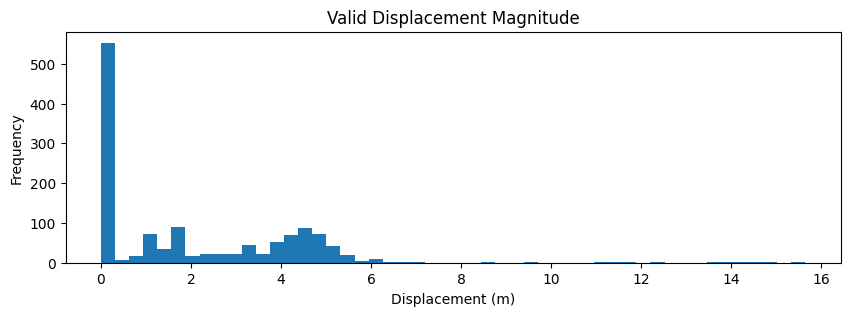

In [ ]:
fig = plt.figure(figsize=(10, 3))
ax = fig.add_subplot(1,1,1)
ax.hist(plot_dm_valid, bins=50)
ax.set_title('Valid Displacement Magnitude')
ax.set_xlabel('Displacement (m)')
ax.set_ylabel('Frequency')

fig.show()

In [ ]:
l_dmx_valid = [l_dmx[i] if l_cr[i] > threshold else None for i in range(len(l_dmx))]
l_dmy_valid = [l_dmy[i] if l_cr[i] > threshold else None for i in range(len(l_dmy))]
l_dm_valid = [l_dm[i] if l_cr[i] > threshold else None for i in range(len(l_dm))]
l_dpx_valid = [l_dpx[i] if l_cr[i] > threshold else None for i in range(len(l_dpx))]
l_dpy_valid = [l_dpy[i] if l_cr[i] > threshold else None for i in range(len(l_dpy))]

In [ ]:
# 出力されたデータの長さを見てみる
len(l_dmx)

1296

In [ ]:
print(len(l_dmx))
print(len(l_dmy))
print(len(l_dm))

1296
1296
1296


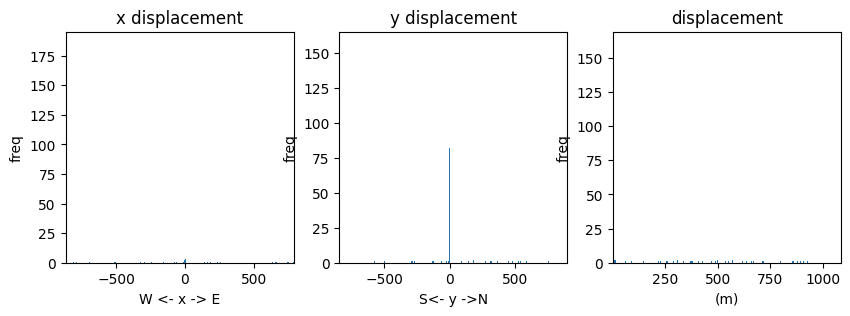

In [ ]:
x_min = min(l_dmx)
x_max = max(l_dmx)
y_min = min(l_dmy)
y_max = max(l_dmy)
d_min = min(l_dm)
d_max = max(l_dm)


fig = plt.figure(figsize=(10, 3))
edges = np.arange(x_min, x_max, 0.5)
ax = fig.add_subplot(1,3,1)
ax.hist(l_dmx, bins=edges)
ax.set_title('x displacement')
ax.set_xlabel('W <- x -> E')
ax.set_ylabel('freq')
ax.set_xlim(x_min, x_max)

ax = fig.add_subplot(1,3,2)
edges = np.arange(y_min, y_max, 0.5)
ax.hist(l_dmy, bins=edges)
ax.set_title('y displacement')
ax.set_xlabel('S<- y ->N')
ax.set_ylabel('freq')
ax.set_xlim(y_min, y_max)

ax = fig.add_subplot(1,3,3)
edges = np.arange(d_min, d_max, 0.5)
ax.hist(l_dm, bins=edges)
ax.set_title('displacement')
ax.set_xlabel('(m)')
ax.set_ylabel('freq')
ax.set_xlim(d_min, d_max)


fig.show()

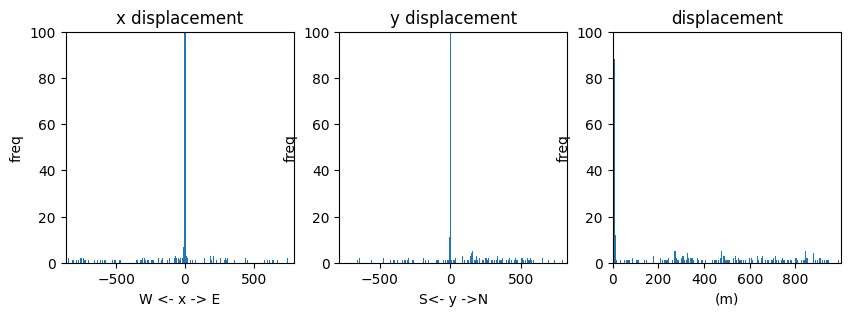

In [ ]:
x_min = min(l_dmx_valid)
x_max = max(l_dmx_valid)
y_min = min(l_dmy_valid)
y_max = max(l_dmy_valid)
d_min = min(l_dm_valid)
d_max = max(l_dm_valid)


fig = plt.figure(figsize=(10, 3))
edges = np.arange(x_min, x_max, 5)
ax = fig.add_subplot(1,3,1)
ax.hist(l_dmx_valid, bins=edges)
ax.set_title('x displacement')
ax.set_xlabel('W <- x -> E')
ax.set_ylabel('freq')
ax.set_xlim(x_min, x_max)
ax.set_ylim(0, 100)

ax = fig.add_subplot(1,3,2)
edges = np.arange(y_min, y_max, 5)
ax.hist(l_dmy_valid, bins=edges)
ax.set_title('y displacement')
ax.set_xlabel('S<- y ->N')
ax.set_ylabel('freq')
ax.set_xlim(y_min, y_max)
ax.set_ylim(0, 100)

ax = fig.add_subplot(1,3,3)
edges = np.arange(d_min, d_max, 5)
ax.hist(l_dm_valid, bins=edges)
ax.set_title('displacement')
ax.set_xlabel('(m)')
ax.set_ylabel('freq')
ax.set_xlim(d_min, d_max)
ax.set_ylim(0, 100)

fig.show()

(0.0, 1.0)

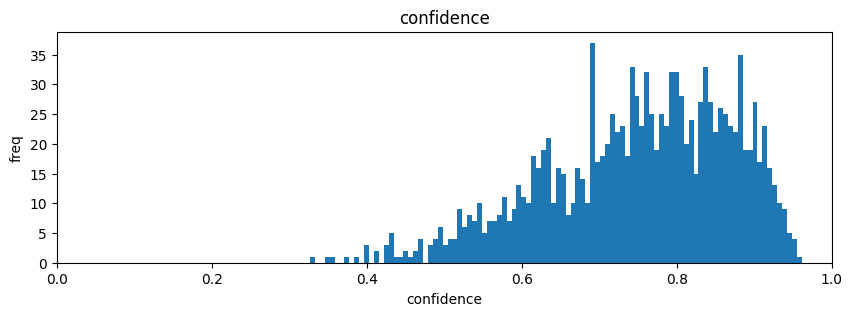

In [ ]:
# 信頼度のヒストグラム
fig = plt.figure(figsize=(10, 3))
ax = fig.add_subplot(1,1,1)
ax.hist(l_cr, bins=100)
ax.set_title('confidence')
ax.set_xlabel('confidence')
ax.set_ylabel('freq')
ax.set_xlim(0, 1)

In [ ]:
# l_dm の最大値
print(f"Maximum displacement (m): {max(l_dm)}")

Maximum displacement (m): 15.652475842498529


In [ ]:
fln = bfs_clipped.split('/')[-1].split('.')[0] + "_w" + str(win_size) +".png"
out_fig_path = "/content/drive/MyDrive/shared_2025JPGU/data/fig"
out_path = os.path.join(out_fig_path, fln)


In [ ]:
out_path